# Loan Risk Assessment using Machine Learning 

 In today's world, each one of us does our best effort to keep our financial records clean. Everytime we plan to buy or rent a property or even buy a credit card, a credit check is run inorder to verify the financial standing of a applicant. Depending on the financial history, a user is offered a good interest rate. 

The Lending loan club is a online platform designed to bring together the investors and borrowers by encouraging a fair monetary transaction of lending and borrowing. This has helped to foster growth of small businesses and let people take control of their debt.

We have built a machine a model which is capable of predicting the eligibility for a loan applicant and interest rate if eligible. Let's begin with understanding how our model is structured.

### Preliminary Step
 An applicant begins with creating an online profile and is required to enter his detail stating his requirements. The system is designed to check the user’s eligibility for the quoted requirement based on his/her financial standing and market situation. The user is intimated about his eligibility and if eligible, the amount for which the loan was sanctioned with the interest rate. This is the most critical aspect and is the business generator for the Lending Club. It has to be ensured that the given interest rate is fair to both the customer and the bank from the transaction point of view.

For our study, we have scraped data from the Lending Club Data website. While the data was readily available on Kaggle, it was not updated(older data). We scraped data for the applicants with their loan request approved and declined for our study. We structured our understanding of the model and drew the below outline.

## Structure of our Model

<img src="Document.jpg">

## Data Download

We created a user profile from a registered email id and built a [LUIGI](LUIGI_Commands) pipeline and used [Beautiful Soup](http://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python) package in order to scrape into [declined.py](declined.py) and [approved.py](loandata.py). The data for each of the cases were downloaded by two separate .py files. These files are attached along with this package. 

## Pre-processing of Data

The downloaded data needed cleaning like removal of punctuations, junk text, white spaces in between and changing data types for operable columns.

### Handling Missing Values

We decided that to delete the columns of whose values were missing for over 80%. For the other columns with values missing below 80%, we filled them up by using mean, median, max of the columns.

Introducing Risk Score column which is a derived column by averaging the max and min FICO score.

### Feature Engineering :

Owing to the size of the data of the loan approved and declined data, we needed to narrow our scope of our input data(over 100 columns) to fewer columns. We studied the input data asked to a new applicant,and selected only those columns and did feature selection for further processing.

Once this is done, we have our files ready for building our model.

# Phase 1 : Assessment of Loan Eligibility - Classification Model

Building the classification model for deciding whether the user is eligible for loan. Below is the code snippet for the classification model with explanation. 

Importing necessary packages

In [1]:
import pandas as pd
# Package imports
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
import pickle

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Reading our data downloaded from the [declined.py](declined.py) and [approved.py](loandata.py) files

In [2]:
declinedata=pd.read_csv('CleanedDeclineddata.csv')
loandata=pd.read_csv('CleanedLoandata.csv',encoding="ISO-8859-1")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (39,105) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Drawing dataframes of the required data for building our classification model and renaming some of the columns

In [3]:
declinedataforclassification=declinedata[['amount_requested','Risk_Score','dti','State','emp_length','policy_code','app_month']]

In [4]:
loandataforclassification=loandata[['loan_amnt','Risk_Score','dti','addr_state','emp_length','policy_code','issue_month']]

In [5]:
loandataforclassification=loandataforclassification.rename(columns={'loan_amnt':'amount_requested','addr_state':'State','issue_month':'app_month'})

In [7]:
loandataforclassification.head(2)

,amount_requested,Risk_Score,dti,State,emp_length,policy_code,app_month
0,5000,737.0,27.65,4,10,1.0,12
1,2500,742.0,1.00,11,1,1.0,12


Assigning numerical values to status column to categorize in each of the dataframes

In [6]:
declinedataforclassification['status']=0
loandataforclassification['status']=1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
loandataforclassification['amount_requested']=loandataforclassification['amount_requested'].astype(float)


Merging the two dataframes into one for further processing

In [8]:
resultdata = loandataforclassification.append(declinedataforclassification,ignore_index=True)

In [9]:
resultdata.columns

Index(['amount_requested', 'Risk_Score', 'dti', 'State', 'emp_length',
       'policy_code', 'app_month', 'status'],
      dtype='object')

In [13]:
resultdata['State'].value_counts()

4     2231889
44    1762524
35    1494234
9     1401428
10     823384
39     751910
36     721319
14     667595
32     631518
28     616913
5      556337
46     548659
22     495120
20     432241
15     401794
43     399398
3      395154
19     382989
48     362290
24     356825
1      333754
41     325489
18     296912
23     281669
49     261761
6      257275
17     245492
34     244176
37     217318
2      214078
38     202540
25     200799
16     181227
11     163210
45     129006
33     117608
21      86302
31      85620
40      81836
30      71179
8       65646
7       63835
50      57942
26      56622
13      41294
0       41244
42      41039
47      37989
51      37210
29      29795
12       8971
27       4976
Name: State, dtype: int64

In [ ]:
resultdata['emp_length'].value_counts()

In [ ]:
resultdata['policy_code'].value_counts()

In [ ]:
resultdata['app_month'].value_counts()

Dividing the data into test and train in the proportion 30%-70%

In [46]:
train, test = train_test_split(resultdata, train_size = 0.7)

Separating the dependent feature 'Status' column into the train_x and test_y 

In [47]:
train_y = train['status']
test_y = test['status']
train_x = train.loc[:, train.columns != 'status']
test_x = test.loc[:, test.columns != 'status']

In [48]:
train_x['State'] = pd.to_numeric(train_x['State'], errors='coerce')
test_x["State"] = pd.to_numeric(test_x["State"],errors='coerce')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
train_x.isnull().sum()

amount_requested    0
Risk_Score          0
dti                 0
State               0
emp_length          0
policy_code         0
app_month           0
dtype: int64

In [50]:
train_x.shape

(13942134, 7)

### Machine Learning algorithms used :

We have applied below machine learning algorithms and evaluated the performance of the data on each model by plotting the ROC curve. 

### Logistic Regression

Intercept:   [-3.68773009]
Coefficient:   [[-3.66660536e-05  3.23994745e-03 -3.36724706e-02 -2.20076632e-02
   1.40732448e-01  5.91454844e+00 -1.51909105e-01]]
[[12674002    33374]
 [    3764  1230994]]
0.9973362757810246


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


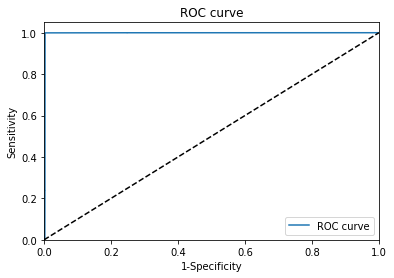

[[5430546   13993]
 [   1606  529056]]
0.9973893765247395


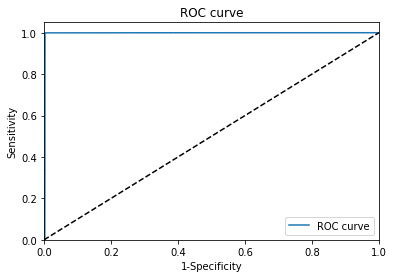

In [51]:
logistic=LogisticRegression()
logistic.fit(train_x,train_y)
print("Intercept:  ",logistic.intercept_)
print("Coefficient:  ",logistic.coef_)


trainpred=logistic.predict(train_x)
traincm=confusion_matrix(train_y, trainpred)
print(traincm)
print(accuracy_score(train_y, trainpred))

trainpreds = logistic.predict_proba(train_x)[:,1]
fpr, tpr, _ = roc_curve(train_y, trainpreds)
#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()






pred=logistic.predict(test_x)
cm=confusion_matrix(test_y, pred)
print(cm)
print(accuracy_score(test_y, pred))

preds = logistic.predict_proba(test_x)[:,1]
fpr, tpr, _ = roc_curve(test_y, preds)
#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()



In [52]:
filename = 'Logistic_regression.sav'
pickle.dump(logistic, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_x, test_y)
print(result)

0.9973893765247395


### Test Accuracy 99.73%
### Train Accuracy 99.73%

## Random Forest Classifier

[[12707376        0]
 [       0  1234758]]
1.0


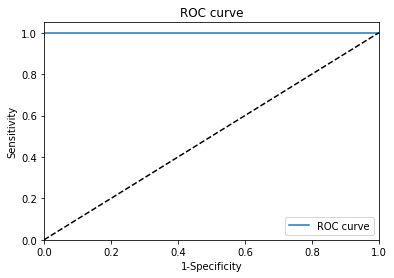

[[5444539       0]
 [      0  530662]]


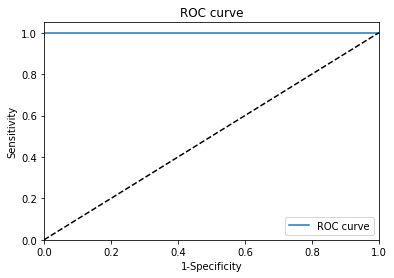

1.0


In [53]:

rf = RandomForestClassifier(n_jobs=2)
rf.fit(train_x, train_y)



trainpred=rf.predict(train_x)
traincm=confusion_matrix(train_y, trainpred)
print(traincm)
print(accuracy_score(train_y, trainpred))

trainpreds = rf.predict_proba(train_x)[:,1]
fpr, tpr, _ = roc_curve(train_y, trainpreds)
#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


preds = rf.predict_proba(test_x)[:,1]
pred=rf.predict(test_x)

cm=confusion_matrix(test_y, pred)
print(cm)


fpr, tpr, _ = roc_curve(test_y, pred)
#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

print(accuracy_score(test_y, pred))

In [54]:
filename = 'Random_Forest_Classifier.sav'
pickle.dump(rf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_x, test_y)
print(result)

1.0


### Test Accuracy 100 %
### Train Accuracy 100 %

## Multi-Layer Perceptron

We were needed to take a sample of our data since it was throwing us memory error

In [55]:
#taking sample data for neural networks otherwise it gives you the memory error
sampledecline=declinedataforclassification.sample(n=10000)
sampleloan=loandataforclassification.sample(n=10000)
resultsampledata = sampleloan.append(sampledecline,ignore_index=True)
train, test = train_test_split(resultdata, train_size = 0.7)
train_y = train['status']
test_y = test['status']
train_x = train.loc[:, train.columns != 'status']
test_x = test.loc[:, test.columns != 'status']

Accuracy on the training subset :0.999187
[[12695179    10824]
 [     504  1235627]]


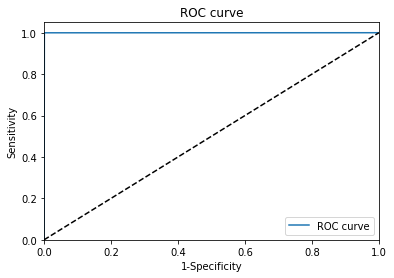

Accuracy on the training subset :0.999201
[[5441378    4534]
 [    239  529050]]


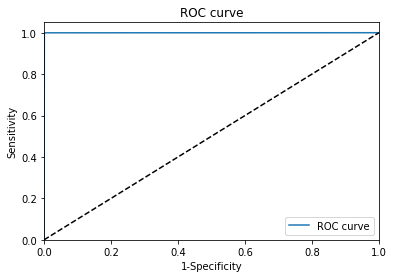

In [56]:
mlp=MLPClassifier(max_iter=100,random_state=42,early_stopping=True,hidden_layer_sizes=10)
mlp.fit(train_x,train_y)



pred=mlp.predict(train_x)
print('Accuracy on the training subset :{:3f}'.format(mlp.score(train_x,train_y)))
cm=confusion_matrix(train_y, pred)
print(cm)
fpr, tpr, _ = roc_curve(train_y, pred)
#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


pred=mlp.predict(test_x)
print('Accuracy on the training subset :{:3f}'.format(mlp.score(test_x,test_y)))
cm=confusion_matrix(test_y, pred)
print(cm)
fpr, tpr, _ = roc_curve(test_y, pred)
#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [57]:
filename = 'Neural_Net_Classifier.sav'
pickle.dump(mlp, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_x, test_y)
print(result)

0.999201198419936


### Test Accuracy 99.91%
### Train Accuracy 99.92%

## Conclusion :

In our case, we got the best model when we used Random Forest Classifier with a train and test accuracy of 100 %.

As per our structure, if a user is not eligible, a message displaying "You are currently not eligible for the loan" is displayed. If eligible, the model moves to the phase 2, where the profile is evaluated for the loan amount and interest sanctioned to the user.

The text in the document by Tushar Goel & Trupti Gore is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

### MIT License

The code in the document by Tushar Goel & Trupti Gore is licensed under the MIT License https://opensource.org/licenses/MIT 

Copyright (c) 2018 Trupti Gore

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
